# Anomaly detection

Output()

HTML(value='')

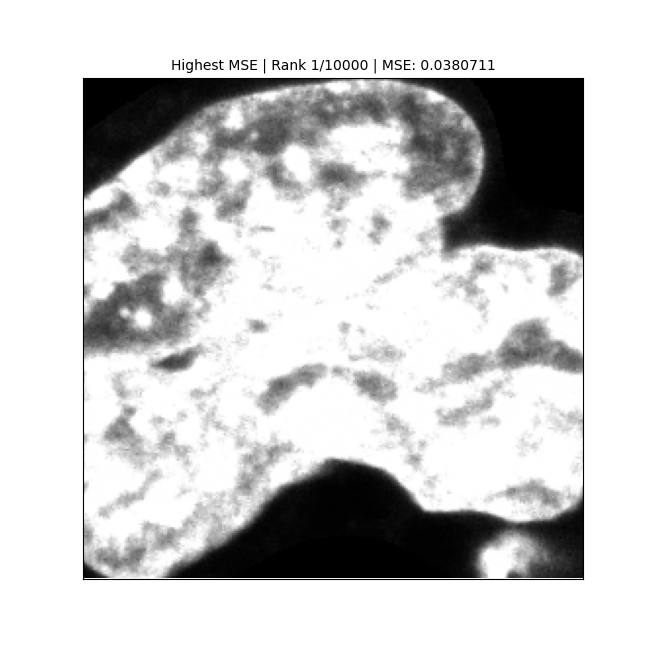

In [1]:
#| label: ae1m-anomaly

try:
    get_ipython().run_line_magic("matplotlib", "widget")  # interactive pan/zoom
except Exception as e:
    raise RuntimeError("ipympl backend required (conda pkg: ipympl)") from e

import os, csv, re
import numpy as np
import ipywidgets as W
import matplotlib.pyplot as plt
from functools import lru_cache
from tifffile import imread as tiff_imread

# ─────────────── CONFIG ───────────────
CSV_PATH        = r"C:\Users\Work\Desktop\Github_repo\cell_browser\data\nucleus-ae\mse_per_image.csv"
BASE_IMAGE_DIR  = r"D:\Confocal_imaging_nuclei_tif\MIST_Fused_Images\ROIs"
TAIL_LIMIT      = 10_000
MARKER          = re.compile(r"(MIST[_ ]?Fused[_ ]?Images[\\/]+ROIs)", re.IGNORECASE)
# ───────────────────────────────────────

def _clean(s: str) -> str:
    return s.strip().strip('"').strip("'")

# Load CSV (filename, mse)
if not os.path.isfile(CSV_PATH):
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")

filenames, mses = [], []
with open(CSV_PATH, "r", newline="") as f:
    reader = csv.reader(f)
    header = next(reader, None)
    if not header or header[0].lower() != "filename":
        f.seek(0); reader = csv.reader(f)
    for row in reader:
        if len(row) < 2:
            continue
        name = _clean(row[0])
        try:
            mse = float(_clean(row[1]))
        except Exception:
            continue
        filenames.append(name); mses.append(mse)

filenames = np.array(filenames, dtype=object)
mses      = np.array(mses, dtype=np.float64)
if len(filenames) == 0:
    raise RuntimeError("No rows parsed from CSV. Check its format.")

N = len(filenames)
K = min(TAIL_LIMIT, N)
order_desc = np.argsort(mses)[::-1]
order_asc  = order_desc[::-1]
top_idx    = order_desc[:K]
bottom_idx = order_asc[:K]

def resolve_path(raw_path: str) -> str | None:
    cand = os.path.normpath(raw_path)
    if os.path.isfile(cand): return cand
    cand2 = cand.replace("/", os.sep).replace("\\\\", "\\")
    if os.path.isfile(cand2): return cand2
    base = os.path.basename(cand2)
    cand3 = os.path.join(BASE_IMAGE_DIR, base)
    if os.path.isfile(cand3): return cand3
    m = MARKER.search(cand2)
    if m:
        pos = m.end()
        tail = cand2[pos:].lstrip("\\/")
        cand4 = os.path.join(BASE_IMAGE_DIR, tail)
        if os.path.isfile(cand4): return os.path.normpath(cand4)
    return None

@lru_cache(maxsize=256)
def load_image_resolved(raw_path):
    resolved = resolve_path(raw_path)
    if not resolved:
        return None, (0, 1), FileNotFoundError("Not found via resolver"), None
    try:
        img = tiff_imread(resolved)
    except Exception as e:
        return None, (0, 1), e, resolved

    # Squeeze grayscale if needed
    if img.ndim == 3 and img.shape[-1] == 1: img = img[..., 0]
    if img.ndim > 2: img = np.asarray(img[..., 0])

    # Native range (for mapping the 0–255 slider to data)
    if img.dtype == np.uint8:
        vmin, vmax = 0, 255
    else:
        vmin = float(np.nanmin(img)); vmax = float(np.nanmax(img))
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            vmin, vmax = 0.0, 1.0
    return img, (vmin, vmax), None, resolved

# ─────────────── Widgets ───────────────
mode = W.ToggleButtons(options=[("Highest MSE", "hi"), ("Lowest MSE", "lo")],
                       value="hi", description="View:")
rank = W.IntSlider(value=1, min=1, max=K, step=1, description="Rank:",
                   continuous_update=False)

btn_prev  = W.Button(description="⟵ Prev", layout=W.Layout(width="85px"))
btn_next  = W.Button(description="Next ⟶", layout=W.Layout(width="85px"))

# Always-on 0–255 display-range slider (no auto-range)
vr_slider = W.IntRangeSlider(value=(0, 255), min=0, max=255, step=1,
                             description="Range:", continuous_update=False, readout=True)

controls_top = W.HBox([mode, rank, btn_prev, btn_next])
controls_bottom = W.HBox([vr_slider])
info = W.HTML(value="")
out = W.Output()  # single render target

display(controls_top, controls_bottom, out, info)

# ─────────────── Figure (created inside Output) ───────────────
state = {"fig": None, "ax": None, "im_artist": None}
with out:
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("")  # placeholder
    state["fig"] = fig
    state["ax"] = ax
    state["im_artist"] = None

def _current_tail():
    return (top_idx, "Highest") if mode.value == "hi" else (bottom_idx, "Lowest")

def _clamp(v, lo, hi):
    return max(lo, min(hi, v))

def _apply_display(img, native_vmin, native_vmax):
    ax = state["ax"]
    if state["im_artist"] is None:
        state["im_artist"] = ax.imshow(img, cmap="gray")
    else:
        state["im_artist"].set_data(img)

    # Map 0–255 slider → native data range
    lo, hi = vr_slider.value
    if img.dtype == np.uint8:
        vmin, vmax = lo, hi
    else:
        span = (native_vmax - native_vmin) if native_vmax > native_vmin else 1.0
        vmin = native_vmin + (lo / 255.0) * span
        vmax = native_vmin + (hi / 255.0) * span
    if vmin >= vmax:
        vmax = vmin + np.finfo(float).eps

    state["im_artist"].set_clim(vmin=vmin, vmax=vmax)

def show_current():
    fig, ax = state["fig"], state["ax"]
    idx_array, label = _current_tail()
    pos  = _clamp(rank.value - 1, 0, len(idx_array) - 1)
    gidx = int(idx_array[pos])
    raw  = filenames[gidx]
    mse  = mses[gidx]

    img, (native_vmin, native_vmax), err, resolved = load_image_resolved(raw)

    ax.clear()
    ax.set_xticks([]); ax.set_yticks([])
    state["im_artist"] = None  # reset artist on each draw (safer with pan/zoom)

    if err is not None or img is None:
        ax.text(0.5, 0.55, "Could not load image",
                ha="center", va="center", fontsize=12, transform=ax.transAxes)
        ax.text(0.5, 0.40, f"Raw CSV path:\n{raw}",
                ha="center", va="center", fontsize=9, transform=ax.transAxes, wrap=True)
        if resolved:
            ax.text(0.5, 0.22, f"Tried resolved:\n{resolved}",
                    ha="center", va="center", fontsize=9, transform=ax.transAxes, wrap=True)
    else:
        _apply_display(img, native_vmin, native_vmax)

    ax.set_title(f"{label} MSE | Rank {pos+1}/{K} | MSE: {mse:.6g}", fontsize=10)
    state["fig"].canvas.draw_idle()

    # Info panel — no Global index
    info.value = (
        f"<b>File:</b> <code>{resolved if err is None else '—'}</code><br>"
        f"<b>MSE:</b> {mse:.8f}"
    )

# ─────────────── Events ───────────────
def _on_mode(change):
    if change["name"] == "value":
        rank.value = _clamp(rank.value, 1, K)
        show_current()

def _on_rank(change):
    if change["name"] == "value":
        show_current()

def _prev(_):
    rank.value = _clamp(rank.value - 1, 1, K)

def _next(_):
    rank.value = _clamp(rank.value + 1, 1, K)

def _on_range(change):
    show_current()

mode.observe(_on_mode, names="value")
rank.observe(_on_rank, names="value")
btn_prev.on_click(_prev)
btn_next.on_click(_next)
vr_slider.observe(_on_range, names="value")

# Initial draw (inside Output)
show_current()
